In [ ]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
local


In [ ]:
def to_dict(obj):
    out = dict(obj.__dict__)  # start with stored attributes
    for name in dir(obj):
        if isinstance(getattr(type(obj), name, None), property):
            out[name] = getattr(obj, name)
    return out

            
import pack_dynamics
importlib.reload(pack_dynamics)
                                                       
@dataclass
class MegaDynamics2(pack_dynamics.DynamicsInitialize):
    # Configuration
    n_trees = 40
    n_ensembles = 1000    
    seed = 42
    size_setup = None
   
    # Results
    sizes = None # n_ensemble rows, n_round columns
    best_size = np.inf
    best_xyt = None
    time = None
    xyt_final = None

    def run_simulation_wrap(self):
        # Initial configuration
        size_setup_scaled = self.size_setup * np.sqrt(self.n_trees)
        xyt = np.random.default_rng(seed=self.seed).uniform(-0.5, 0.5, size=(self.n_ensembles, self.n_trees, 3))
        xyt = xyt * [[[size_setup_scaled, size_setup_scaled, np.pi]]]
        xyt = np.array(xyt, dtype=np.float32)
        self.sizes = np.ndarray((self.n_ensembles,))
        h = np.array([[2*size_setup_scaled,0.,0.]]*self.n_ensembles, dtype=np.float32)
        print(h.shape)

        sol = kgs.SolutionCollection()
        sol.xyt= cp.array(xyt)
        sol.h = cp.array(h)

        sol = self.run_simulation(sol)
        xyt,h = sol.xyt, sol.h
        self.xyt_final = xyt
        
        # Report out
        overlaps = pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0]
        # Compute edge of smallest axis-aligned square containing all tree polygons for each ensemble
        for ei in range(self.n_ensembles):
            try:
                tree_list_local = kgs.TreeList()
                tree_list_local.xyt = cp.asnumpy(xyt[ei])
                polygons = tree_list_local.get_trees()
                # collect all vertex coordinates
                xs = []
                ys = []
                for poly in polygons:
                    for vx, vy in poly.exterior.coords[:-1]:
                        xs.append(vx)
                        ys.append(vy)
                    # include interior rings if present
                    for interior in poly.interiors:
                        for vx, vy in interior.coords[:-1]:
                            xs.append(vx)
                            ys.append(vy)
                min_x = min(xs) if xs else 0.0
                max_x = max(xs) if xs else 0.0
                min_y = min(ys) if ys else 0.0
                max_y = max(ys) if ys else 0.0
                edge = float(max(max_x - min_x, max_y - min_y))
                self.sizes[ei] = edge
            except:
                self.sizes[ei] = np.nan                    
            #if overlaps[ei] > 0.0001*np.sqrt(self.n_trees):
            #    self.sizes[ei] = np.nan
            if self.sizes[ei] < self.best_size:
                self.best_size = self.sizes[ei]
                self.best_xyt = cp.asnumpy(xyt[ei]) 
                

            
                                                       


local
Preallocate for cost
local
Preallocate for cost


0
(100, 3)


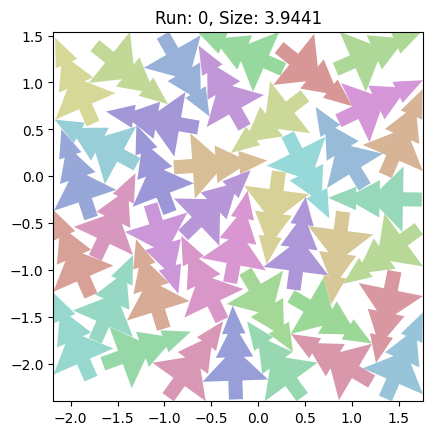

1
(100, 3)


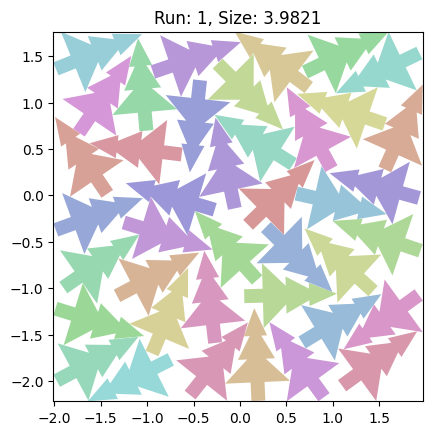

2
(100, 3)


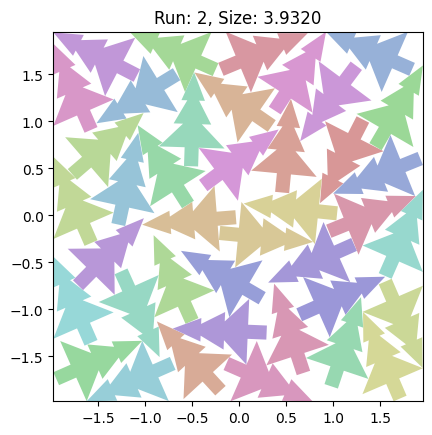

3
(100, 3)


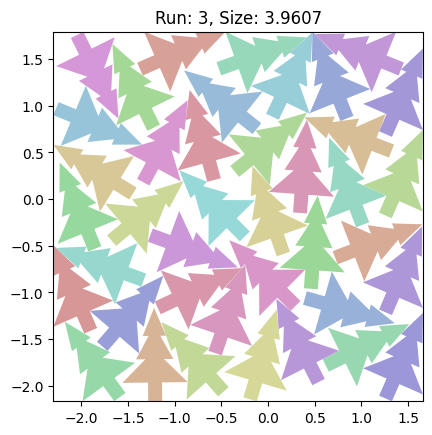

4
(100, 3)


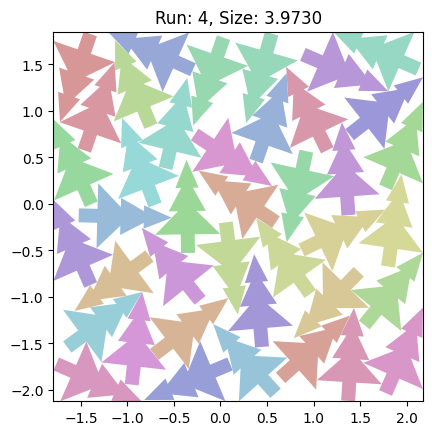

5
(100, 3)


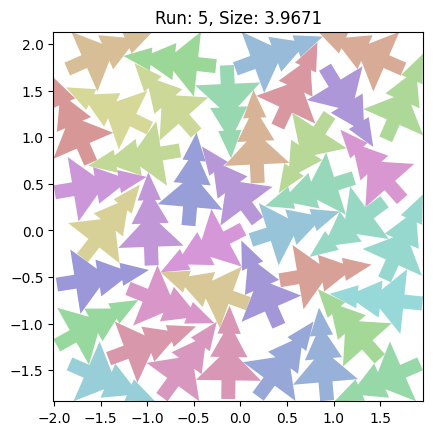

6
(100, 3)


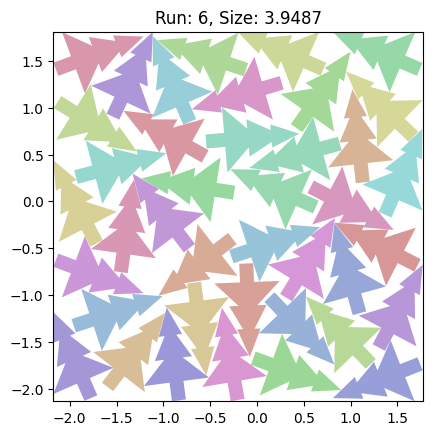

7
(100, 3)


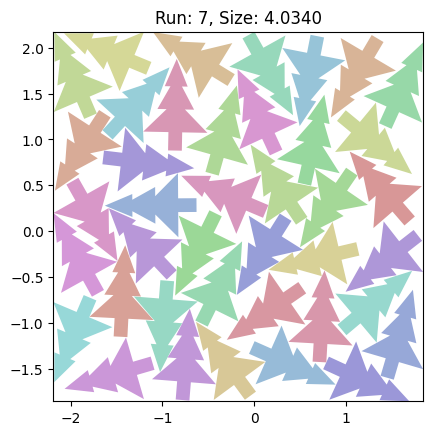

8
(100, 3)


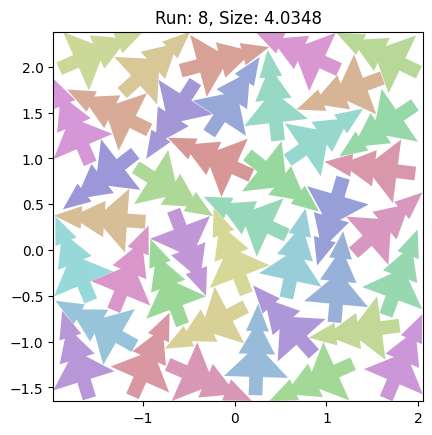

9
(100, 3)


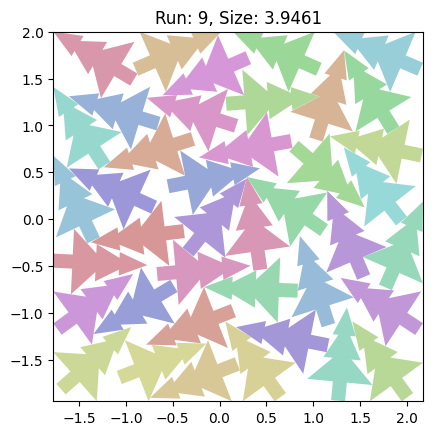

10
(100, 3)


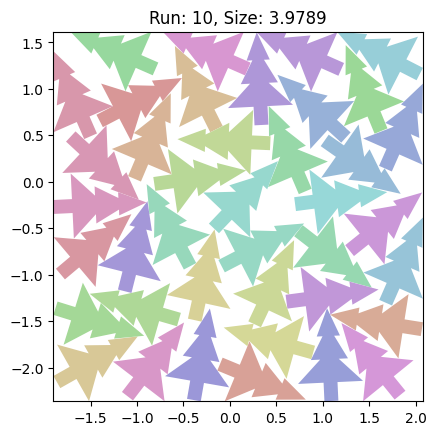

11
(100, 3)


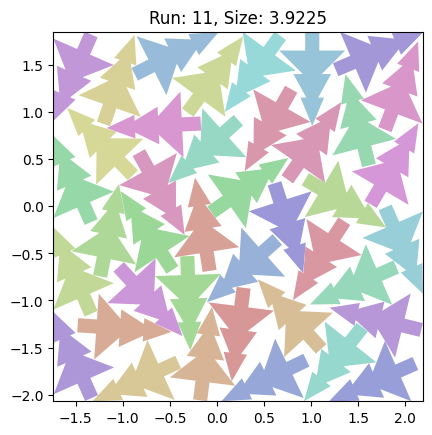

12
(100, 3)


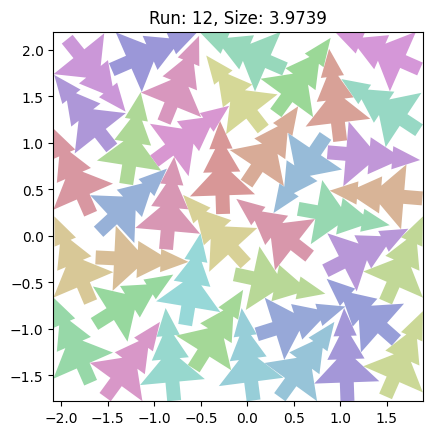

13
(100, 3)


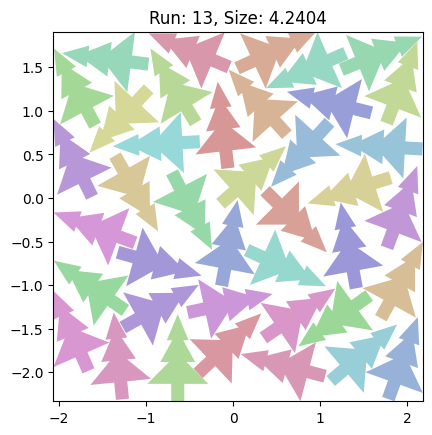

14
(100, 3)


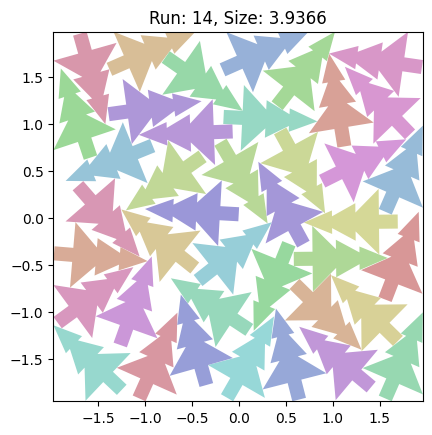

15
(100, 3)


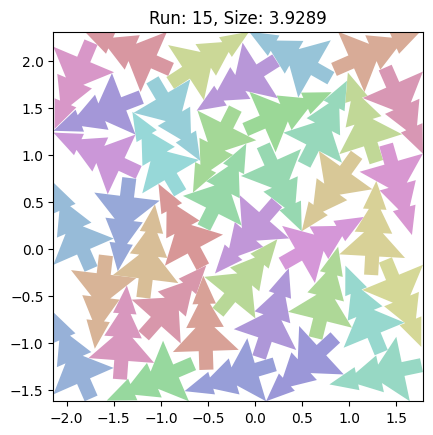

16
(100, 3)


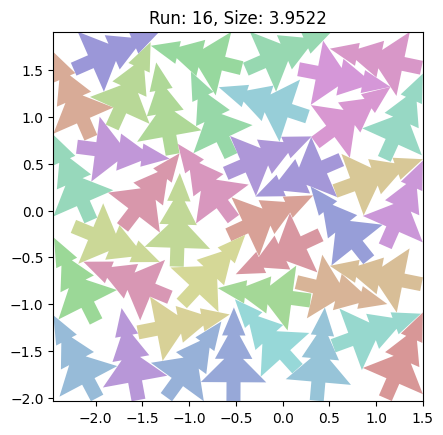

17
(100, 3)


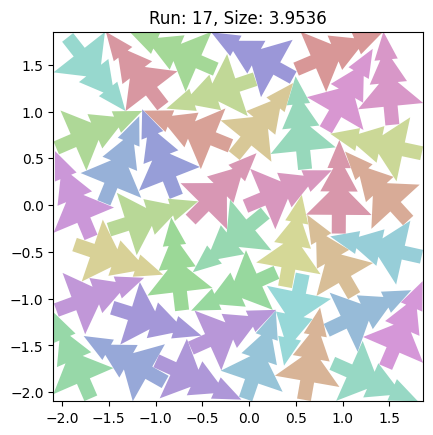

18
(100, 3)


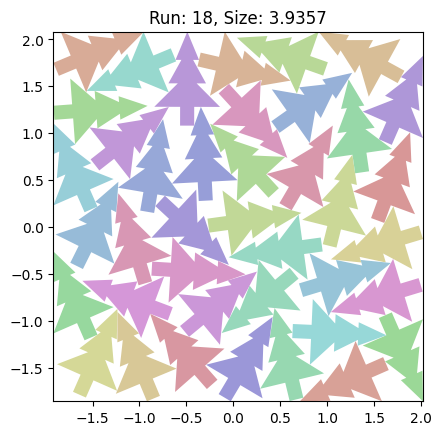

19
(100, 3)


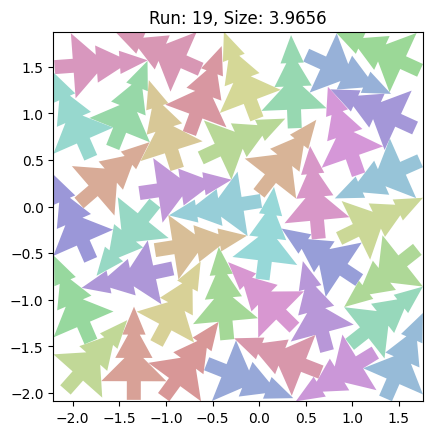

20
(100, 3)


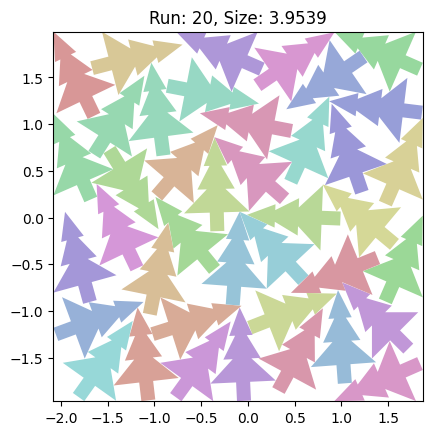

21
(100, 3)


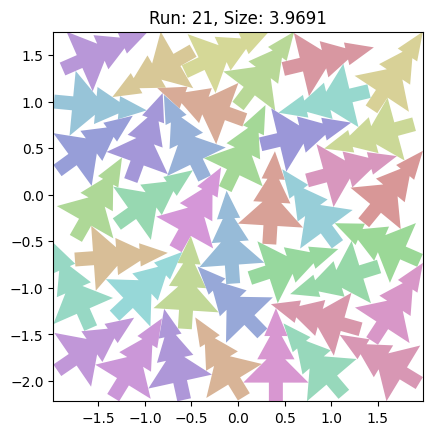

22
(100, 3)


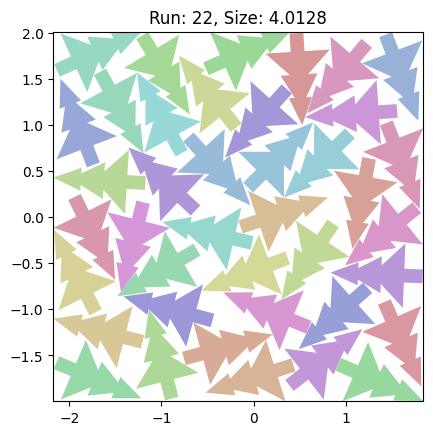

23
(100, 3)


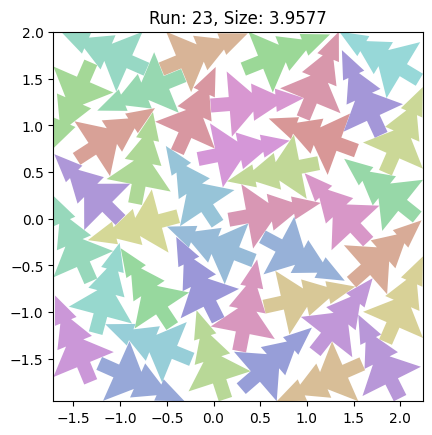

24
(100, 3)


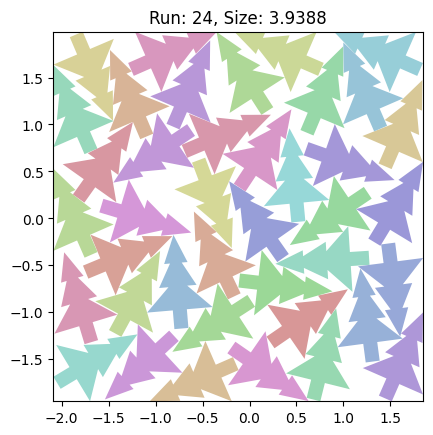

25
(100, 3)


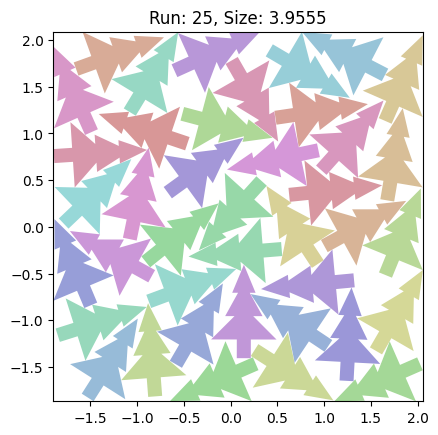

26
(100, 3)


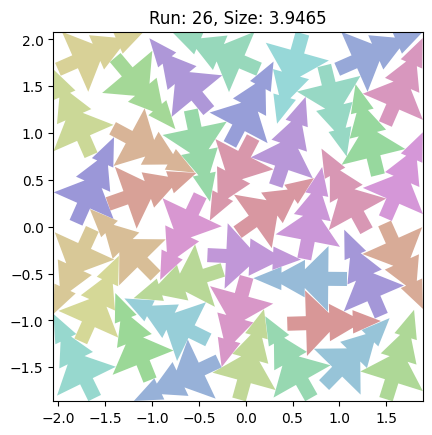

27
(100, 3)


In [ ]:
runner_list = []
base_runner = MegaDynamics2()
base_runner.n_trees = 40
base_runner.n_ensembles = 1000
base_runner.n_rounds = 10
base_runner.plot_interval = None
gen = np.random.default_rng(seed=12345)
for i in range(100000):
    print(i)
    runner = copy.deepcopy(base_runner)
    runner.seed = i 
    runner.size_setup = 0.65#gen.uniform(0.5,0.8)
    runner.duration_init = gen.uniform(0., 20.)
    runner.duration_compact = gen.uniform(150.,200.)
    runner.dt = gen.uniform(0.03, 0.04)
    runner.scaling_area_start = 10.*10**gen.uniform(-0.5,0.) # range quite carefully checked - but before friction
    runner.scaling_area_end = 10.*10**gen.uniform(-4., -3.5)
    runner.scaling_boundary = 10.*5.#gen.uniform(1., 10**1.5)
    runner.scaling_overlap = 10.#gen.uniform(5.,15.)
    runner.use_boundary_distance = True#gen.choice([True, False])
    runner.friction_min = gen.uniform(0.1,0.3)
    runner.friction_max = 0.
    runner.friction_periods = gen.choice([1,2,3,4])
    #runner.friction = 0.01#gen.uniform(0.01,0.3)
    runner.run_simulation_wrap()
    runner_list.append(runner)
    kgs.dill_save(kgs.temp_dir + 'runner_dt_mom_vary6.pickle', [to_dict(r) for r in runner_list])
    tree_list = kgs.TreeList()
    tree_list.xyt = runner.best_xyt
    pack_vis.visualize_tree_list(tree_list)
    plt.title(f'Run: {i}, Size: {runner.best_size:.4f}')
    plt.pause(0.001)
